I used stemming in this project since stemming get rid of the suffixes and prefixes while at the same time, it preserves the positivity and negativity of the verb which can conveys critical information regarding the semantic of the sentence. Moreover, the title and the comment sections are merged together.

posterior = posterior of a sentence can be calucated by the given formula in the discription. However, posterior of a word means : (number of the word 'x in c class / total number of the word 'x')

likelihood = number of the word x in c class / total number of the words in c class

prior = number of the words in c class / total number of the words 

evidence = number of the word 'x' / total number of the words


if 'digikala' exists in a class and not in the other, it will couse the posterior probability to be 0 in the class that it does not exist in since the likelihood would be 0 therefore the model can classify with false certainty

In order to calculate the likelihood, additive smoothing changes the formula from X / N to (x + alpha) / (N + alpha*d). In this formula, alpha is a hyper parameter, N is the total number of words in a class, and d is the number of the distict words in the said class. By using the additive smoothing, the likelihood term would always be greater than zero therefore it will prevent the posterior probability to become zero and lose the valuable information regarding other words. 

for rare cancer datamodeling, false-negatives are extremely important therefore recall is a critical factor.


for youtube recommendation false negatives are not that important therefore precision is a better criterion

F1 score is the harmonic mean between the precisio and the recall of a model. It combines the imformation in the precision and in the recall criteria. It provides a balance between these two method. It is used when we need this balance and the dataset is not even. 




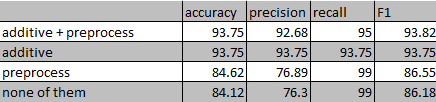

Regarding the F1 and accuracy scores, additive+preprocess mode yeilds the best result. Additive smoothing is much more effective than preprocessing. preprocessing does not seem to have significant effect in the result. However, removing additvie smoothing couses the recall to be 99 percent which means that the recommended class has more of the unique words than the not_recommended one. 

I suppose that negative verbs in conjunction with positive adjectives are most likely to cause error in the classification. If there woulb be an method to detect role of the words in a sentence then we could assign weights to verbs and adjectives.

In [143]:
import pandas as pd 
from __future__ import unicode_literals
from hazm import *

In [144]:

class Naive_baise:
  def __init__(self, stop_words):
    self.norm = Normalizer()
    self.stemer =Stemmer()

    self.rec_dict = {}
    self.nrec_dict = {}

    self.rec_cnt = 0
    self.nrec_cnt = 0

    self.stop_words = stop_words 
    self.false_preds = []


  def fit_model(self, data_add, preprocess):
    comment_df = pd.read_csv(data_add)

    for ind, row in comment_df.iterrows():
      rec = 1 if row['recommend'] == 'recommended' else 0 

      cmt = row['comment'] + row['title']
      cmt = self.norm.normalize(cmt)
      sents = sent_tokenize(cmt)

      for s in sents:
        words = word_tokenize(s)

        for w in words:
          if preprocess == True:
            if w in self.stop_words:
              continue
            
            w = self.stemer.stem(w)

          if rec == 1:
            self.rec_cnt += 1
            if w in self.rec_dict:
              self.rec_dict[w] += 1
            else:
              self.rec_dict[w] = 1
            
          elif rec == 0:
            self.nrec_cnt += 1
            if w in self.nrec_dict:
              self.nrec_dict[w] += 1
            else:
              self.nrec_dict[w] = 1
    

  def test_model(self, test_add, alpha, preprocess):
    test_df = pd.read_csv(test_add)
    true_pred = 0
    false_pred = 0 
    true_negative = 0
    true_positive = 0

    false_negative = 0
    false_positive = 0

    for ind, row in test_df.iterrows():
      cmt = row['comment'] + row['title']
      cmt = self.norm.normalize(cmt)
      sents = sent_tokenize(cmt)
      sent_set = set([])

      for s in sents:
        words = word_tokenize(s)

        for w in words:
          if preprocess == True:
            if w in self.stop_words:
              continue 

            w = self.stemer.stem(w)

          sent_set.add(w)

      p_1 = float((rec_cnt)/(rec_cnt + nrec_cnt))
      p_0 = float((nrec_cnt)/(rec_cnt + nrec_cnt))

      for w in sent_set:

        if w in self.rec_dict:
          p_w1 = float((self.rec_dict[w] + alpha)/(self.rec_cnt + alpha*len(self.rec_dict)))
        else:
          p_w1 = float(alpha / (self.rec_cnt + alpha*len(self.rec_dict)))

        if w in self.nrec_dict:
          p_w0 = float((self.nrec_dict[w] + alpha)/(self.nrec_cnt + alpha*len(self.nrec_dict)))
        else:
          p_w0 = float(alpha / (self.nrec_cnt + alpha*len(self.nrec_dict)))

        p_1 *= p_w1
        p_0 *= p_w0

      if p_1 >= p_0:
        pred = 'recommended'
      else:
        pred = 'not_recommended'

      if pred == row['recommend']:
        true_pred += 1
      else:
        self.false_preds.append(row['comment'])
        false_pred += 1

      if pred == 'recommended' and row['recommend'] == 'recommended':
        true_positive += 1

      if pred == 'recommended' and row['recommend'] == 'not_recommended':
        false_positive += 1

      if pred == 'not_recommended' and row['recommend'] == 'recommended':
        false_negative += 1
      
      if pred == 'not_recommended' and row['recommend'] == 'not_recommended':
        true_negative += 1

    N = len(test_df)
    accu = float(true_pred / N) * 100 
    preci = float(true_positive / (true_positive + false_positive)) * 100 
    reca = float(true_positive / (true_positive + false_negative)) * 100 
    F1 = 2*float((preci * reca)/(preci + reca)) 

    print('accuracy:{} F1:{}'.format(accu, F1))
    print('precision:{} recall:{}'.format(preci, reca))


In [145]:
stop_words = '. ، ! و : ؛ من تو او ما شما اونا آنها به از در با حتی اگر اگه اما ولی بود هست شد ه ها های اون که'.split(' ')
nb = Naive_baise(stop_words)

nb.fit_model('comment_train.csv', True)
nb.test_model('comment_test.csv', 0.01, True)
falses = [nb.false_preds[i] for i in range(5)]

for cm in falses:
  print(cm)

      


accuracy:93.75 F1:93.82716049382717
precision:92.6829268292683 recall:95.0
سلام ، راحت شدم از کابل شارژ ، توصیه میشود به شدت . ارزان گوشی خود را به شارژ وایرلس مجهز کنید .
فندک قبلیم مدام فیوز میسوزوند و یک بار شارژر موبایل هم سوزوند ولی با این هیچ مشکلی بوجود نیومده تا الان. کیفیتش خیلی خوبه و لامپ هم داره
، دوستان عزیز دقت کنند در مورد خرید این پاوربانک خیلی مهمه چون من خریدم دوبار خرید زدم و دقت کن از سری a و سری b خیلی تفاوت ها با همدیگه دارند یکی از مهمترین تفاوت هایی که دارند اینه که سری b سه تا خروجی ۶ آمپر داره اما خروجی های سری ایدم پرو یک آمپر هستش خیلی دقت کنید من خرید زدم بعدش که آوردم باز کردم می بینم که اون چیزی که سفارش دادم نیستش بعد پولتونو که بخواهیم پس بگیرین حدود ۲۰ روز طول میکشه هفت روز طول میکشه که این جعبه رو واستون برگردوند و بعدش ۷ روز طول میکشه که حدود اینکه پولتونو بهتون بدن خریدی که من زدم نه تنها مغایرت داشت بلکه خود دستگاه هم خراب بود  حتی شارژ نمی‌کرد میزاری داخل شارژ به سرعت شارژش تموم میشد و تمام چراغ هاشم خراب بود خودش شارژرش هم مشکل داشت راه خود شارژ 